In [14]:
#http://francescopochetti.com/stock-market-prediction-part-introduction/
import cPickle
import pystocks

import numpy as np
import pandas as pd
import datetime
from datetime import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import TimeSeriesSplit
import operator
from IPython.display import display
from sklearn.qda import QDA
import re
from dateutil import parser
from backtest import Strategy, Portfolio
import quandl 
import os
import sys


print os.getcwd()

/Users/parksoy/Desktop/GoogleDrive_Soyoung/Udacity_nanoDegree_MachineLearning/capstone


In [15]:
#Execute to prepare dataset

symbol='INTC'

#Redownload and create return
dataset = pd.read_csv('./data/'+ symbol + '.csv', index_col="Date", parse_dates=True)
index_rev=dataset.index.sort_values(ascending=True)
dataset=pd.DataFrame(dataset, index=index_rev)

dataset['Return'] = dataset['Adj Close'].pct_change() 
columns = dataset.columns 
adjclose = columns[-2]
returns = columns[-1]

#Add features
lags = [7,14,28]
deltas =[7,14,28] 

for delta in deltas:
    return_delta = adjclose[9:] + "simpleReturn_" + str(delta)
    dataset[return_delta] = dataset[adjclose].pct_change(delta)
    
    roll_delta = returns[7:] + "simpleReturnMA_" + str(delta)
    dataset[roll_delta] = dataset[returns].rolling(window=delta,center=False).mean()

#Take care of NA
dataset = dataset.interpolate(method='linear')
dataset = dataset.fillna(dataset.mean())

display(dataset[:7])

dataset.Return = dataset.Return.shift(-1)
maxLag = max(lags)
columns =[col for col in list(dataset.columns) if col.startswith("Return")] 
for column in columns:
    for lag in lags:
        newcolumn = column + "_"+str(lag)
        dataset[newcolumn] = dataset[column].shift(lag)
dataset=dataset.iloc[maxLag:-1,:]

display(dataset[:7])
print dataset.shape

,Open,High,Low,Close,Volume,Adj Close,Return,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28
Date,,,,,,,,,,,,,
1997-01-02,131.7500,132.000,127.625000,130.375,97639200,11.206980,0.000528,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-03,133.0000,138.500,132.625000,138.375,95648000,11.894656,0.061361,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-06,139.1250,141.750,137.750000,138.875,120549600,11.937636,0.003613,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-07,138.5625,143.500,137.000000,143.375,96153600,12.324454,0.032403,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-08,144.0000,145.625,141.765594,142.250,125510400,12.227750,-0.007847,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-09,143.3750,144.000,141.750000,143.000,77420000,12.292219,0.005272,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506
1997-01-10,142.1250,144.750,141.500000,144.500,111907200,12.421159,0.010490,0.003279,0.000514,0.006406,0.000513,0.012838,0.000506


,Open,High,Low,Close,Volume,Adj Close,Return,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28,Return_7,Return_14,Return_28
Date,,,,,,,,,,,,,,,,
1997-02-11,154.125,154.750,146.500000,151.750,151842400,13.048687,0.032949,-0.064715,-0.009247,-0.002135,0.000078,0.164336,0.005686,0.010015,-0.002465,0.061361
1997-02-12,151.750,157.000,150.500000,156.750,112742400,13.478627,0.001595,-0.043478,-0.005971,0.033291,0.002607,0.133167,0.004672,0.005339,-0.008237,0.003613
1997-02-13,158.000,159.000,156.000000,157.000,96499200,13.500124,-0.015924,-0.047041,-0.006506,0.043535,0.003309,0.130888,0.004600,-0.045524,-0.002492,0.032403
1997-02-14,156.125,157.000,153.500000,154.500,69313600,13.285154,0.000809,-0.017488,-0.002277,0.029483,0.002350,0.077951,0.002874,-0.026232,0.005829,-0.007847
1997-02-18,154.250,155.125,152.125000,154.625,60033600,13.295903,-0.004850,0.009796,0.001586,0.024346,0.001991,0.087355,0.003183,0.021225,0.025174,0.005272
1997-02-19,154.125,155.750,153.250000,153.875,55190400,13.231412,-0.025995,-0.015987,-0.002139,-0.005654,-0.000153,0.076405,0.002821,-0.030376,0.034733,0.010490
1997-02-20,152.250,153.000,149.359299,149.875,128985600,12.887459,-0.023353,-0.011542,-0.001513,-0.064013,-0.004491,0.037541,0.001518,0.000824,0.013271,0.016436


(5051, 16)


In [59]:
def split_to_feature_Binary_target(dataset, lag):
     
    #Feature sets:
    col_list = list(dataset.columns.values)
    features = [item for item in col_list if item.startswith("simple")] #not
    X = dataset[features] 
    
    #Binary classification target
    le = preprocessing.LabelEncoder()
    target_col='Return_'+str(lag)

    dataset['UpDown'] = dataset[target_col]
    dataset.UpDown[dataset.UpDown >= 0] = 'Up'
    dataset.UpDown[dataset.UpDown < 0] = 'Down'
    dataset.UpDown = le.fit(dataset.UpDown).transform(dataset.UpDown)
    y = pd.DataFrame(dataset.UpDown, index=dataset.index)
    
    return X,y
    

from scipy.stats import zscore #Scale all features based on z-score 

def scaleFeature_timeseriessplit(X,y):
    
    X_z=X.apply(zscore)
    tscv = TimeSeriesSplit(n_splits=3)

    for train_index, test_index in tscv.split(X):
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test = X_z.iloc[train_index], X_z.iloc[test_index]
    
    return X_train, y_train, X_test, y_test   

X,y=split_to_feature_Binary_target(dataset, lag)
X_train, y_train, X_test, y_test=scaleFeature_timeseriessplit(X,y)

print X_train.shape, y_train.shape, X_test.shape, y_test.shape

display(X_train[:3])
display(y_train[:3])


(3789, 6) (3789, 1) (1262, 6) (1262, 1)


/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,simpleReturn_7,simpleReturnMA_7,simpleReturn_14,simpleReturnMA_14,simpleReturn_28,simpleReturnMA_28
Date,,,,,,
1997-02-11,-1.143145,-1.148881,-0.101552,-0.071497,1.286465,1.236439
1997-02-12,-0.785258,-0.762372,0.331563,0.359888,1.021767,0.994240
1997-02-13,-0.845299,-0.825481,0.456804,0.479656,1.002412,0.977033


,UpDown
Date,
1997-02-11,1
1997-02-12,1
1997-02-13,1


In [60]:
type(y_train.values)
print y_train.as_matrix().ravel().shape

(3789,)


In [62]:
#Classification with all models

def perform_Classification(X_train, y_train, X_test, y_test, method, parameters, savemodel):

    y_train=y_train.as_matrix().ravel()
    y_test=y_test.as_matrix().ravel()
    
    clf = method
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    
    if clf==RandomForestClassifier(n_estimators=1000, n_jobs=-1):
        importance=clf.feature_importances_
        indices = np.argsort(importance)[::-1]
        for f in range(X_train.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importance[indices[f]]))
    if savemodel == True:
        fname_out = '{}-{}.pickle'.format(symbol, datetime.now())
        with open(fname_out, 'wb') as f:
            cPickle.dump(clf, f, -1)    
    
    y_pred=clf.predict(X_test)
    acc_score=clf.score(X_test, y_test)
    f1_score=metrics.f1_score(y_test, y_pred) 
    
    classifiers_f1.update({method.__class__.__name__: f1_score})
    return acc_score,f1_score

#Set model and parameters and run classification
savemodel=False
method=RandomForestClassifier(n_estimators=1000, n_jobs=-1)
parameters = [1, 2, 50, 1] #SVC: C=1, gamma=2, AdaBoost=n_estimators = parameters[3], learning_rate =  parameters[4]

methods=[RandomForestClassifier(n_estimators=1000, n_jobs=-1),
         neighbors.KNeighborsClassifier(),
         SVC(C=parameters[0],gamma=parameters[1]), # C=1, gamma=2,
         AdaBoostClassifier(n_estimators=parameters[2],learning_rate=parameters[3]), #n = parameters[0],l =  parameters[1]
         GradientBoostingClassifier(n_estimators=100)
        ]

classifiers_f1={}
for method in methods:
    perform_Classification(X_train, y_train, X_test, y_test, method, parameters, savemodel)
    
print classifiers_f1

{'KNeighborsClassifier': 0.53416149068322971, 'AdaBoostClassifier': 0.59064327485380108, 'SVC': 0.63714285714285712, 'GradientBoostingClassifier': 0.61483594864479307, 'RandomForestClassifier': 0.5718562874251496}


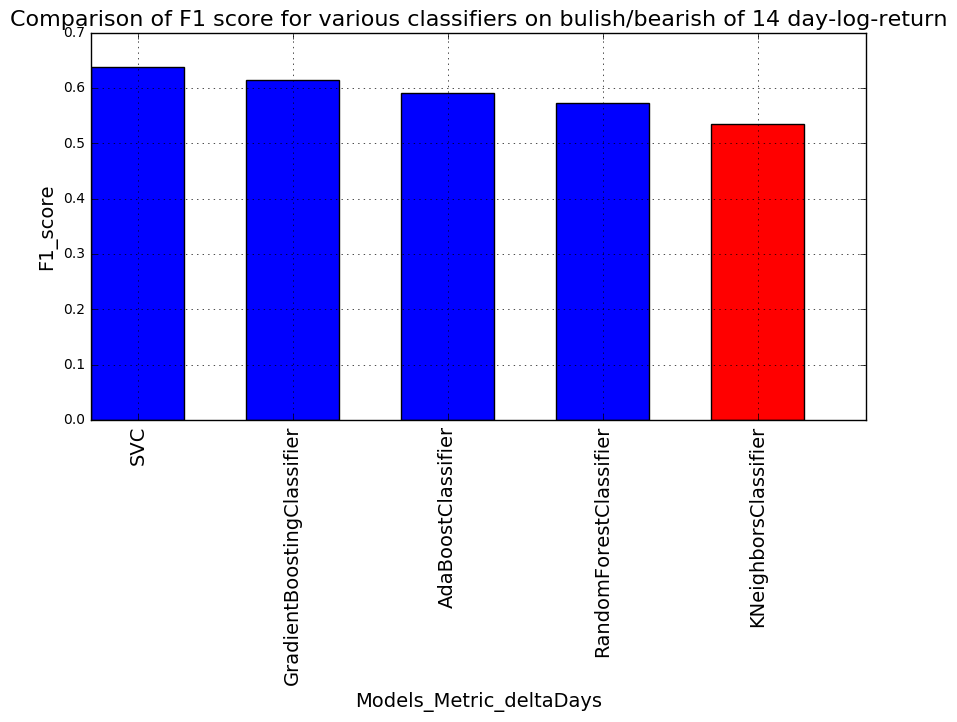

,key,f1_score
2,SVC,0.637143
3,GradientBoostingClassifier,0.614836
1,AdaBoostClassifier,0.590643
4,RandomForestClassifier,0.571856
0,KNeighborsClassifier,0.534161


In [63]:
#summary of RMSE for all classifiers

import matplotlib.pyplot as plt


classifiers_f1_df=pd.DataFrame(list(classifiers_f1.iteritems()), columns=['key','f1_score'])
classifiers_f1_df=classifiers_f1_df.sort_values(by=['f1_score'],ascending=False)

plt.rcParams['figure.figsize'] = (10.0, 5.0)

colors = []
for model in classifiers_f1_df.key: 
    if model.startswith('KNeighbors'):
        colors.append('r')
    else:
        colors.append('b')

ind = np.arange(len(classifiers_f1))
fig = plt.figure()
ax = fig.add_subplot(111)
bar_width = 0.6
ax.bar(ind,classifiers_f1_df['f1_score'], width=bar_width, color=colors) 

ax.set_ylabel('F1_score',fontsize=14)
ax.set_xlabel('Models_Metric_deltaDays',fontsize=14)
plt.xticks(ind + bar_width / 2, classifiers_f1_df['key'],rotation='vertical',fontsize=14)

ax.grid('on')
ax.set_title('Comparison of F1 score for various classifiers on bulish/bearish of 14 day-log-return',fontsize=16)
plt.show()

display(classifiers_f1_df[:10])

In [69]:
print np.array([100, 1000])
print type(np.array([100, 1000]))
print type([100, 1000])

[ 100 1000]
<type 'numpy.ndarray'>
<type 'list'>


In [76]:
np.array([100, 1000])

clf_sets=[(methods[0],[100, 1000])]
#(clf, cs, X, y)
for i, (clf, param) in enumerate(clf_sets):
    print i
    print ""
    print clf
    print ""
    print param

0

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

[100, 1000]


In [95]:
#Let's do gridsearch CV

from sklearn import preprocessing

#ORIGINAL DATASET X,y
X,y=split_to_feature_Binary_target(dataset, lag)
y=y.as_matrix().ravel()
  
method=methods[0]

#Do GridSearchCV

from sklearn.model_selection import GridSearchCV

#Define grid parameters, method

methods=[LogisticRegression(),
         RandomForestClassifier(n_estimators=1000, n_jobs=-1),
         neighbors.KNeighborsClassifier(),
         SVC(C=1,gamma=2), 
         AdaBoostClassifier(n_estimators=2,learning_rate=0.05), #n = parameters[0],l =  parameters[1]
         GradientBoostingClassifier(n_estimators=100)
        ]

#Working piece
train_size=0.7
tscv = TimeSeriesSplit(n_splits=3)
cv=tscv.split(X)


clf_sets=[(methods[0],[100, 1000])]

for i, (clf, param) in enumerate(clf_sets):
    print i, param
    param_grid = dict(n_estimators=param)
    grid_search = GridSearchCV(clf, refit=False, param_grid=param_grid, cv=cv,scoring='f1')

grid_search.fit(X, y)
display(grid_search.cv_results_)

#http://stackoverflow.com/questions/32889929/gridsearchcv-scoring-parameter-using-scoring-f1-or-scoring-none-by-default-u
    
print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()
#for param_name in sorted(parameters.keys()):
#    print '\t%s: %r' % (param_name, best_parameters[param_name])

#predictions = grid_search.predict(X_test)
    

/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0 [100, 1000]


{'mean_fit_time': array([ 1.18537633,  8.33940125]),
 'mean_score_time': array([ 0.25682529,  1.68665735]),
 'mean_test_score': array([ 0.52421448,  0.52924849]),
 'mean_train_score': array([ 1.,  1.]),
 'param_n_estimators': masked_array(data = [100 1000],
              mask = [False False],
        fill_value = ?),
 'params': ({'n_estimators': 100}, {'n_estimators': 1000}),
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_test_score': array([ 0.49202351,  0.49625312]),
 'split0_train_score': array([ 1.,  1.]),
 'split1_test_score': array([ 0.53115265,  0.52242329]),
 'split1_train_score': array([ 1.,  1.]),
 'split2_test_score': array([ 0.54946728,  0.56906907]),
 'split2_train_score': array([ 1.,  1.]),
 'std_fit_time': array([ 0.2140587 ,  1.17296188]),
 'std_score_time': array([ 0.04840314,  0.13101592]),
 'std_test_score': array([ 0.023959 ,  0.0301162]),
 'std_train_score': array([ 0.,  0.])}

Best score: 0.529
Best parameters set:


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [93]:
print X.shape
print tscv.split(X)

(5051, 6)
<generator object split at 0x118689960>


In [112]:
#Let's get GridSearch work

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model.logistic import LogisticRegression
method=DecisionTreeClassifier(criterion='entropy',random_state=20000)

X,y=split_to_feature_Binary_target(dataset, lag)
y=y.as_matrix().ravel()

'''
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=100000)
print X_train.shape, y_train.shape
'''

from sklearn.pipeline import Pipeline

pipeline=Pipeline([('clf',LogisticRegression())])


parameters = {
    'clf__penalty': ('l1','l2'),
    'clf__C': (0.01, 1),
} 

tscv = TimeSeriesSplit(n_splits=10)
cv=tscv.split(X)

grid_search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=cv,verbose=1,scoring='f1') # cv=cv, verbose=1, 
grid_search.fit(X, y) #_train

print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)
from sklearn.metrics import classification_report
print classification_report(y_test, predictions)



Fitting 10 folds for each of 4 candidates, totalling 40 fits


/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Best score: 0.656
Best parameters set:
	clf__C: 0.01
	clf__penalty: 'l2'
             precision    recall  f1-score   support

          0       0.58      0.05      0.09       596
          1       0.53      0.97      0.69       667

avg / total       0.55      0.53      0.41      1263



[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.8s finished


In [147]:
#Add one more estimator:This is awesome
#http://scikit-learn.org/stable/modules/pipeline.html

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline


X,y=split_to_feature_Binary_target(dataset, lag)
y=y.as_matrix().ravel()

#pipeline=Pipeline([('clf1',LogisticRegression()),('clf2',SVC())])
pipeline=make_pipeline(LogisticRegression(), SVC()) 

print pipeline.steps[1]
print pipeline.named_steps['logisticregression']


('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [156]:
print X.shape

(5051, 6)


In [158]:
pipeline=make_pipeline(LogisticRegression(), SVC()) 

parameters = dict(
            logisticregression__C=[0.01, 1,10],
            svc__C=[1, 10]
            )
    
tscv = TimeSeriesSplit(n_splits=3)
cv=tscv.split(X)

grid_search = GridSearchCV(pipeline, parameters,n_jobs=-1,cv=cv,verbose=1,scoring='f1') # cv=cv, verbose=1, 
grid_search.fit(X, y) #_train

print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()

print "***************************************"

for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])

predictions = grid_search.predict(X_test)
print "***************************************"
print "cv_results_=\n", 
display(grid_search.cv_results_)

from sklearn.metrics import classification_report

print "***************************************"
print "Classification_report:\n"
print classification_report(y_test, predictions)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: F

Best score: 0.603
Best parameters set:
***************************************
	logisticregression__C: 1
	svc__C: 10
***************************************
cv_results_=


/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


{'mean_fit_time': array([ 0.72480877,  0.84820803,  0.71770279,  0.70172207,  0.60961   ,
         0.53510507]),
 'mean_score_time': array([ 0.20651627,  0.17707801,  0.19746065,  0.18177597,  0.17497365,
         0.1392053 ]),
 'mean_test_score': array([ 0.53433959,  0.57222234,  0.59920638,  0.60349377,  0.59920638,
         0.60349377]),
 'mean_train_score': array([ 0.54369361,  0.55970361,  0.5955618 ,  0.6053972 ,  0.5955618 ,
         0.6053972 ]),
 'param_logisticregression__C': masked_array(data = [0.01 0.01 1 1 10 10],
              mask = [False False False False False False],
        fill_value = ?),
 'param_svc__C': masked_array(data = [1 10 1 10 1 10],
              mask = [False False False False False False],
        fill_value = ?),
 'params': ({'logisticregression__C': 0.01, 'svc__C': 1},
  {'logisticregression__C': 0.01, 'svc__C': 10},
  {'logisticregression__C': 1, 'svc__C': 1},
  {'logisticregression__C': 1, 'svc__C': 10},
  {'logisticregression__C': 10, 'svc__C': 1

***************************************
Classification_report:

             precision    recall  f1-score   support

          0       0.58      0.43      0.50       596
          1       0.59      0.72      0.65       667

avg / total       0.58      0.58      0.58      1263



In [127]:
methods=[LogisticRegression(),
         RandomForestClassifier(), #n_estimators=1000, n_jobs=-1
         neighbors.KNeighborsClassifier(),
         SVC(), #C=1,gamma=2
         AdaBoostClassifier(n_estimators=2,learning_rate=0.05), 
         GradientBoostingClassifier(n_estimators=10) #n_estimators=100
        ]

grdboost=GradientBoostingClassifier(n_estimators=10) 

from IPython.display import display
print "LogisticRegression=="
display(LogisticRegression().get_params())
print ""
print "RandomForestClassifier="
display(RandomForestClassifier().get_params())
print ""
print "Kneighbors="
display(neighbors.KNeighborsClassifier().get_params())
print ""
print "SVC="
display(SVC().get_params())
print ""
print "Adaboost="
display(AdaBoostClassifier().get_params())
print ""
print "GradientBoosting="
display(GradientBoostingClassifier().get_params())
print ""
print "XGBClassifier="
display(XGBClassifier().get_params())

LogisticRegression==


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


RandomForestClassifier=


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Kneighbors=


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


SVC=


{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


Adaboost=


{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}


GradientBoosting=


{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


XGBClassifier=


{'base_score': 0.5,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': -1,
 'objective': 'binary:logistic',
 'seed': 0,
 'silent': True,
 'subsample': 1}

In [125]:
from xgboost import XGBClassifier

In [163]:
#https://miguelmalvarez.com/2015/02/23/python-and-kaggle-feature-selection-multiple-models-and-grid-search/
from sklearn.feature_selection import VarianceThreshold
from collections import Counter

# Fitting a feature selector
def feature_selection(train_instances):
    print('Crossvalidation started... ')
    selector = VarianceThreshold()
    selector.fit(train_instances)
    print('Number of features used... ' +
              str(Counter(selector.get_support())[True]))
    print('Number of features ignored... ' +
              str(Counter(selector.get_support())[False]))
    return selector

train_instances=X
#Learn the features to filter from train set
fs = feature_selection(train_instances)
 
#Transform train and test subsets
train_instances = fs.transform(train_instances)
#test_instances = fs.transform(test_instances)

Crossvalidation started... 
Number of features used... 6
Number of features ignored... 0


In [234]:
# Example code for a model and a set of grid-search parameters
model = RandomForestClassifier(random_state=1)
parameters = [{"n_estimators": [250, 500]}]
judgements=y
cv=3

# Returns the best configuration for a model using crosvalidation and grid search
def best_hyperparameter(model, parameters, X, y):
    print 'Grid search for... ' , model.__class__.__name__, 'in the space : ',parameters
    cv=tscv.split(X)
    grid_search = GridSearchCV(model, parameters, cv=cv, scoring="f1", verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    best_estimator = grid_search.best_estimator_
    print "........Best_hyperparameter_set=",str(grid_search.best_params_)
    return [best_estimator,  grid_search.best_score_, str(grid_search.best_params_)]


[model, score, param]=best_hyperparameter(model, parameters, X, y)

print "\n****RESULT of best_hyperparameter****\n",
print "**Best_estimator=",model
print "**Best_hyperparameters=",param
print "**Best_f1_score=",score

Grid search for...  RandomForestClassifier in the space :  [{'n_estimators': [250, 500]}]
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   15.3s finished


........Best_hyperparameter_set= {'n_estimators': 250}

****RESULT of best_hyperparameter****
**Best_estimator= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)
**Best_hyperparameters= {'n_estimators': 250}
**Best_f1_score= 0.536231427652


In [240]:
# Returns the best model from a set of model families given
# training data using cross-validation.
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

tscv = TimeSeriesSplit(n_splits=3)
classifiers_f1={}

# Returns the best configuration for a model using crosvalidation and grid search
def best_hyperparameter(model, parameters, X, y):
    print 'Grid search for... ' , model.__class__.__name__, 'in the space : ',parameters
    cv=tscv.split(X)
    grid_search = GridSearchCV(model, parameters, cv=cv, scoring="f1", verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    best_estimator = grid_search.best_estimator_
    print "........Best_hyperparameter_set=",str(grid_search.best_params_), "with f1 score=",grid_search.best_score_
    classifiers_f1.update({best_estimator.__class__.__name__: grid_search.best_score_})
    
    return [best_estimator,  grid_search.best_score_, str(grid_search.best_params_)]


def best_model(set_model_hyperparameter, X, y):
    best_score = 0.0
    best_model_score_param = None
    model_score_parameter = []
    
    for name, model, parameters in set_model_hyperparameter:
        model_score_parameter.append(best_hyperparameter(model,parameters,X,y))
 
    for model, score, parameter in model_score_parameter:
        if (score > best_score):
            best_score = score
            best_model_score_param = [model, score, parameter]
 
    return best_model_score_param
 
def set_model_hyperparameter():
    set_model_param = []

    #RandomForest
    rf_parameters = [{"n_estimators": [10, 100, 250, 500], #
                      'bootstrap': [False,True]}]
    set_model_param.append(["RandomForest",RandomForestClassifier(n_jobs=-1),rf_parameters])
    
    #SVC
    svm_parameters = [{'kernel': ['poly','rbf'],
                       'degree': [1, 2, 3]}]
    set_model_param.append(["SVM", SVC(),svm_parameters])
    
    
    #Knn
    knn_parameters = [{"n_neighbors": [3, 5],
                       'leaf_size': [10,30,50] }]
    set_model_param.append(["kNN", neighbors.KNeighborsClassifier(n_jobs=-1),knn_parameters])
    
    #Logistic
    logistic_parameters=[{'C': [0.01,0.1,1.0],
                          'solver': ['liblinear','sag']}]
    set_model_param.append(["logistic", LogisticRegression(n_jobs=-1),logistic_parameters])
    
    #Adaboost
    adaboost_parameters=[{'learning_rate': [0.05,0.5,1.0],
                          'n_estimators': [5,50]}]
    set_model_param.append(["adaboost", AdaBoostClassifier(),adaboost_parameters])
    
    #GradientBoost
    gboosting_parameters=[{'learning_rate': [0.01,0.1,1],
                           'max_depth': [3,10],
                           'n_estimators': [10,100]}]
    set_model_param.append(["gboosting", GradientBoostingClassifier(),gboosting_parameters])
    
    #XGBoost
    xgb_parameters=[{'gamma': [0,1],
                     'learning_rate': [0.01,0.1,1],
                     'max_depth': [3,10],
                     'n_estimators': [10,100]}]
    set_model_param.append(["xgb", XGBClassifier(),xgb_parameters])

    return set_model_param

set_model_hyperparameter=set_model_hyperparameter()
best_model=best_model(set_model_hyperparameter, X, y)

print "\n************RESULT OF BEST_MODEL:******************\n", 
print "Best_model: ", best_model[0],
print ""
print "\nBest_f1_score: ", best_model[1],
print "\nBest_hyperparameter: ",best_model[2]

Grid search for...  RandomForestClassifier in the space :  [{'n_estimators': [10, 100, 250, 500], 'bootstrap': [False, True]}]
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   34.8s finished


........Best_hyperparameter_set= {'n_estimators': 500, 'bootstrap': False} with f1 score= 0.535119730242
Grid search for...  SVC in the space :  [{'kernel': ['poly', 'rbf'], 'degree': [1, 2, 3]}]
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.1s finished


........Best_hyperparameter_set= {'kernel': 'poly', 'degree': 2} with f1 score= 0.683387368561
Grid search for...  KNeighborsClassifier in the space :  [{'n_neighbors': [3, 5], 'leaf_size': [10, 30, 50]}]
Fitting 3 folds for each of 6 candidates, totalling 18 fits
........Best_hyperparameter_set= {'n_neighbors': 5, 'leaf_size': 10} with f1 score= 0.523519447019
Grid search for...  LogisticRegression in the space :  [{'C': [0.01, 0.1, 1.0], 'solver': ['liblinear', 'sag']}]
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.7s finished


........Best_hyperparameter_set= {'C': 0.01, 'solver': 'sag'} with f1 score= 0.666939820275
Grid search for...  AdaBoostClassifier in the space :  [{'n_estimators': [5, 50], 'learning_rate': [0.05, 0.5, 1.0]}]
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.9s finished


........Best_hyperparameter_set= {'n_estimators': 50, 'learning_rate': 0.5} with f1 score= 0.578771099899
Grid search for...  GradientBoostingClassifier in the space :  [{'n_estimators': [10, 100], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 10]}]
Fitting 3 folds for each of 12 candidates, totalling 36 fits
........Best_hyperparameter_set= {'n_estimators': 10, 'learning_rate': 0.01, 'max_depth': 3} with f1 score= 0.649028900351
Grid search for...  XGBClassifier in the space :  [{'n_estimators': [10, 100], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 10], 'gamma': [0, 1]}]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    7.5s finished


........Best_hyperparameter_set= {'n_estimators': 10, 'learning_rate': 0.01, 'max_depth': 3, 'gamma': 0} with f1 score= 0.617813959396

************RESULT OF BEST_MODEL:******************
Best_model:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Best_f1_score:  0.683387368561 
Best_hyperparameter:  {'kernel': 'poly', 'degree': 2}


In [241]:
print classifiers_f1

{'LogisticRegression': 0.66693982027467202, 'KNeighborsClassifier': 0.52351944701923936, 'XGBClassifier': 0.61781395939593653, 'RandomForestClassifier': 0.53511973024188597, 'AdaBoostClassifier': 0.5787710998987895, 'SVC': 0.68338736856105442, 'GradientBoostingClassifier': 0.64902890035100591}


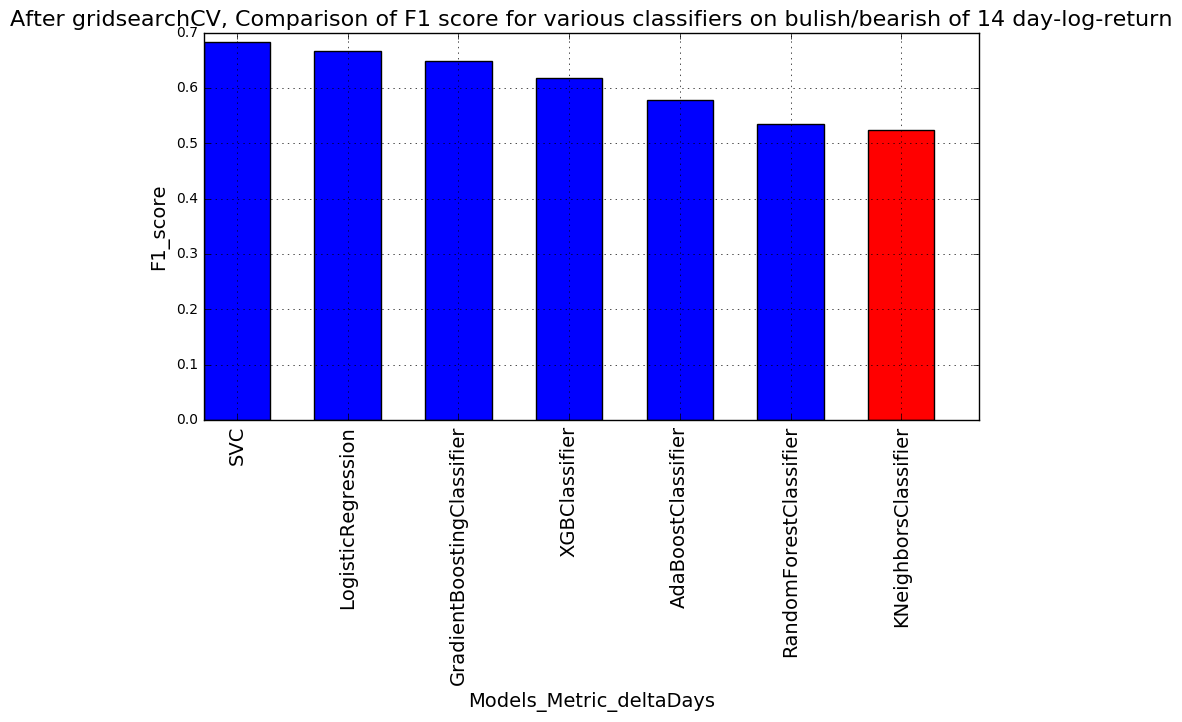

,key,f1_score
5,SVC,0.683387
0,LogisticRegression,0.666940
6,GradientBoostingClassifier,0.649029
2,XGBClassifier,0.617814
4,AdaBoostClassifier,0.578771
3,RandomForestClassifier,0.535120
1,KNeighborsClassifier,0.523519


In [242]:
#summary of RMSE for all classifiers

import matplotlib.pyplot as plt

classifiers_f1_df=pd.DataFrame(list(classifiers_f1.iteritems()), columns=['key','f1_score'])
classifiers_f1_df=classifiers_f1_df.sort_values(by=['f1_score'],ascending=False)

plt.rcParams['figure.figsize'] = (10.0, 5.0)

colors = []
for model in classifiers_f1_df.key: 
    if model.startswith('KNeighbors'):
        colors.append('r')
    else:
        colors.append('b')

ind = np.arange(len(classifiers_f1))
fig = plt.figure()
ax = fig.add_subplot(111)
bar_width = 0.6
ax.bar(ind,classifiers_f1_df['f1_score'], width=bar_width, color=colors) 

ax.set_ylabel('F1_score',fontsize=14)
ax.set_xlabel('Models_Metric_deltaDays',fontsize=14)
plt.xticks(ind + bar_width / 2, classifiers_f1_df['key'],rotation='vertical',fontsize=14)

ax.grid('on')
ax.set_title('After gridsearchCV, Comparison of F1 score for various classifiers on bulish/bearish of 14 day-log-return',fontsize=16)
plt.show()

display(classifiers_f1_df[:10])